# 🚀 NASA Kepler Exoplanet Classification - Model Training

**Objective**: Train and evaluate multiple machine learning models on the processed NASA Kepler dataset to classify exoplanet candidates vs. false positives.

**Dataset**: 9,564 KOIs with 43 engineered features  
**Target**: Binary classification (FALSE POSITIVE vs CANDIDATE)  
**Classes**: Perfectly balanced (50.7% vs 49.3%)  

## 📋 Training Pipeline Overview:
1. **Load Processed Data** - Clean datasets with astronomy-aware preprocessing
2. **Baseline Models** - Logistic Regression, Random Forest, XGBoost
3. **Advanced Models** - LightGBM, Neural Networks, Ensemble Methods
4. **Comprehensive Evaluation** - Cross-validation with multiple metrics
5. **Model Comparison** - Performance analysis and selection
6. **Feature Importance** - Understanding key discriminative features

## 1. Import Libraries and Setup

In [2]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import time
import json
from typing import Dict, List, Tuple, Any

# Machine Learning - Core
from sklearn.model_selection import (
    StratifiedKFold, cross_val_score, cross_validate, 
    GridSearchCV, RandomizedSearchCV, train_test_split
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    precision_recall_curve, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Advanced ML libraries
try:
    import xgboost as xgb
    HAS_XGBOOST = True
    print("✅ XGBoost available")
except ImportError:
    HAS_XGBOOST = False
    print("⚠️ XGBoost not available - install with: pip install xgboost")
    
try:
    import lightgbm as lgb
    HAS_LIGHTGBM = True
    print("✅ LightGBM available")
except ImportError:
    HAS_LIGHTGBM = False
    print("⚠️ LightGBM not available - install with: pip install lightgbm")

# Visualization setup
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("🎯 NASA Kepler Exoplanet Classification - Model Training Notebook")
print("📦 All core libraries imported successfully!")

✅ XGBoost available
✅ LightGBM available
🎯 NASA Kepler Exoplanet Classification - Model Training Notebook
📦 All core libraries imported successfully!


## 2. Load and Inspect Processed Data

We'll load our cleaned datasets that were processed with the astronomy-aware missing value handling strategy.

In [3]:
# Load the processed datasets
print("📂 Loading processed NASA Kepler datasets...")

# Load training and test data
train_df = pd.read_csv('data/processed_v2/clean_train.csv')
test_df = pd.read_csv('data/processed_v2/clean_test.csv')

# Separate features and targets
X_train = train_df.drop('target', axis=1)
y_train = train_df['target']
X_test = test_df.drop('target', axis=1)
y_test = test_df['target']

print(f"✅ Data loaded successfully!")
print(f"📊 Training set: {X_train.shape[0]:,} samples × {X_train.shape[1]} features")
print(f"📊 Test set: {X_test.shape[0]:,} samples × {X_test.shape[1]} features")

# Check class distribution
print(f"\n🎯 Class Distribution:")
train_dist = y_train.value_counts().sort_index()
test_dist = y_test.value_counts().sort_index()
print(f"Training set:")
print(f"  Class 0 (FALSE POSITIVE): {train_dist[0]:,} ({train_dist[0]/len(y_train):.1%})") 
print(f"  Class 1 (CANDIDATE): {train_dist[1]:,} ({train_dist[1]/len(y_train):.1%})")
print(f"Test set:")
print(f"  Class 0 (FALSE POSITIVE): {test_dist[0]:,} ({test_dist[0]/len(y_test):.1%})")
print(f"  Class 1 (CANDIDATE): {test_dist[1]:,} ({test_dist[1]/len(y_test):.1%})")

# Show feature names
print(f"\n📋 Feature Names (first 10):")
for i, feature in enumerate(X_train.columns[:10]):
    print(f"  {i+1:2d}. {feature}")
print(f"  ... and {len(X_train.columns)-10} more features")

# Basic statistics
print(f"\n📈 Dataset Statistics:")
print(f"  No missing values: {X_train.isnull().sum().sum() == 0}")
print(f"  Feature types: {X_train.dtypes.value_counts().to_dict()}")
print(f"  Memory usage: {(X_train.memory_usage(deep=True).sum() + X_test.memory_usage(deep=True).sum()) / 1024**2:.1f} MB")

📂 Loading processed NASA Kepler datasets...
✅ Data loaded successfully!
📊 Training set: 7,651 samples × 43 features
📊 Test set: 1,913 samples × 43 features

🎯 Class Distribution:
Training set:
  Class 0 (FALSE POSITIVE): 3,877 (50.7%)
  Class 1 (CANDIDATE): 3,774 (49.3%)
Test set:
  Class 0 (FALSE POSITIVE): 970 (50.7%)
  Class 1 (CANDIDATE): 943 (49.3%)

📋 Feature Names (first 10):
   1. dec
   2. koi_depth
   3. koi_depth_err1
   4. koi_depth_err2
   5. koi_duration
   6. koi_duration_err1
   7. koi_duration_err2
   8. koi_fpflag_co
   9. koi_fpflag_ec
  10. koi_fpflag_nt
  ... and 33 more features

📈 Dataset Statistics:
  No missing values: True
  Feature types: {dtype('float64'): 39, dtype('int64'): 4}
  Memory usage: 3.1 MB


## 3. Model Classes and Utilities

Let's define our model classes and evaluation utilities for consistent training and comparison.

In [4]:
# Model evaluation utilities
def evaluate_model_cv(model, X, y, cv_folds=5, model_name="Model"):
    """Comprehensive cross-validation evaluation of a model"""
    print(f"🔄 Evaluating {model_name} with {cv_folds}-fold CV...")
    
    # Set up cross-validation
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    # Define scoring metrics
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall', 
        'f1': 'f1',
        'roc_auc': 'roc_auc'
    }
    
    # Perform cross-validation
    start_time = time.time()
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    training_time = time.time() - start_time
    
    # Calculate statistics
    results = {}
    for metric in scoring.keys():
        scores = cv_results[f'test_{metric}']
        results[f'{metric}_mean'] = np.mean(scores)
        results[f'{metric}_std'] = np.std(scores)
        print(f"  {metric:<10}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
    
    results['training_time'] = training_time
    print(f"  ⏱️ Training time: {training_time:.2f}s")
    
    return results, cv_results

def plot_cv_results(cv_results, model_name):
    """Visualize cross-validation results"""
    metrics = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_roc_auc']
    
    fig, axes = plt.subplots(1, len(metrics), figsize=(20, 4))
    fig.suptitle(f'{model_name} - Cross-Validation Results', fontsize=16)
    
    for i, metric in enumerate(metrics):
        scores = cv_results[metric]
        axes[i].boxplot(scores)
        axes[i].set_title(metric.replace('test_', '').title())
        axes[i].set_ylabel('Score')
        axes[i].grid(True, alpha=0.3)
        
        # Add mean line
        axes[i].axhline(np.mean(scores), color='red', linestyle='--', alpha=0.7, label=f'Mean: {np.mean(scores):.3f}')
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()

def compare_models_table(results_dict):
    """Create a comparison table of all models"""
    comparison_data = []
    
    for model_name, results in results_dict.items():
        comparison_data.append({
            'Model': model_name,
            'Accuracy': f"{results['accuracy_mean']:.4f} ± {results['accuracy_std']:.4f}",
            'Precision': f"{results['precision_mean']:.4f} ± {results['precision_std']:.4f}", 
            'Recall': f"{results['recall_mean']:.4f} ± {results['recall_std']:.4f}",
            'F1-Score': f"{results['f1_mean']:.4f} ± {results['f1_std']:.4f}",
            'ROC-AUC': f"{results['roc_auc_mean']:.4f} ± {results['roc_auc_std']:.4f}",
            'Time (s)': f"{results['training_time']:.2f}"
        })
    
    return pd.DataFrame(comparison_data).sort_values('Accuracy', ascending=False)

print("✅ Model evaluation utilities defined!")

✅ Model evaluation utilities defined!


## 4. Baseline Models Training

Let's start with our three baseline models: Logistic Regression, Random Forest, and XGBoost.

In [11]:
# Initialize results storage
all_results = {}
all_cv_results = {}
trained_models = {}

print("🚀 Starting Baseline Model Training...")
print("=" * 50)

🚀 Starting Baseline Model Training...


### 4.1 Logistic Regression (Interpretable Baseline)

In [12]:
# Logistic Regression - Fast, interpretable baseline
lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced',  # Handle any remaining class imbalance
    C=1.0  # Default regularization
)

# Evaluate with cross-validation
lr_results, lr_cv_results = evaluate_model_cv(lr_model, X_train, y_train, model_name="Logistic Regression")

# Store results
all_results['Logistic Regression'] = lr_results
all_cv_results['Logistic Regression'] = lr_cv_results

# Train on full training set for feature importance
lr_model.fit(X_train, y_train)
trained_models['Logistic Regression'] = lr_model

# Feature importance (absolute coefficients)
feature_importance_lr = np.abs(lr_model.coef_[0])
top_features_lr = sorted(zip(X_train.columns, feature_importance_lr), key=lambda x: x[1], reverse=True)[:10]

print(f"\n🔍 Top 10 Most Important Features (Logistic Regression):")
for i, (feature, importance) in enumerate(top_features_lr, 1):
    print(f"  {i:2d}. {feature:<25} {importance:.4f}")

print(f"\n✅ Logistic Regression completed!")

🔄 Evaluating Logistic Regression with 5-fold CV...
  accuracy  : 0.9141 ± 0.0097
  precision : 0.9092 ± 0.0119
  recall    : 0.9176 ± 0.0103
  f1        : 0.9134 ± 0.0098
  roc_auc   : 0.9780 ± 0.0080
  ⏱️ Training time: 6.83s

🔍 Top 10 Most Important Features (Logistic Regression):
   1. koi_score                 5.3369
   2. koi_fpflag_co             4.0116
   3. koi_fpflag_ss             3.2715
   4. koi_fpflag_ec             2.1689
   5. koi_depth_missing         0.6795
   6. koi_prad_missing          0.6795
   7. koi_steff_missing         0.6795
   8. log_koi_prad              0.4952
   9. koi_teq                   0.4032
  10. log_koi_depth             0.3867

✅ Logistic Regression completed!


### 4.2 Random Forest (Robust Baseline)

In [13]:
# Random Forest - Robust, handles feature interactions well
rf_model = RandomForestClassifier(
    n_estimators=300,  # Good balance of performance vs speed
    max_depth=20,      # Prevent overfitting but allow complexity
    min_samples_split=5,  # Conservative splitting
    min_samples_leaf=2,   # Small leaves for detailed decisions
    max_features='sqrt',  # Random feature subsampling
    random_state=42,
    n_jobs=-1,  # Use all cores
    class_weight='balanced'
)

# Evaluate with cross-validation
rf_results, rf_cv_results = evaluate_model_cv(rf_model, X_train, y_train, model_name="Random Forest")

# Store results
all_results['Random Forest'] = rf_results
all_cv_results['Random Forest'] = rf_cv_results

# Train on full training set for feature importance
rf_model.fit(X_train, y_train)
trained_models['Random Forest'] = rf_model

# Feature importance
feature_importance_rf = rf_model.feature_importances_
top_features_rf = sorted(zip(X_train.columns, feature_importance_rf), key=lambda x: x[1], reverse=True)[:10]

print(f"\n🔍 Top 10 Most Important Features (Random Forest):")
for i, (feature, importance) in enumerate(top_features_rf, 1):
    print(f"  {i:2d}. {feature:<25} {importance:.4f}")

print(f"\n✅ Random Forest completed!")

🔄 Evaluating Random Forest with 5-fold CV...
  accuracy  : 0.9820 ± 0.0034
  precision : 0.9848 ± 0.0050
  recall    : 0.9785 ± 0.0073
  f1        : 0.9816 ± 0.0035
  roc_auc   : 0.9985 ± 0.0005
  ⏱️ Training time: 5.37s

🔍 Top 10 Most Important Features (Random Forest):
   1. koi_score                 0.2634
   2. koi_fpflag_nt             0.1407
   3. koi_fpflag_co             0.1160
   4. koi_fpflag_ss             0.0956
   5. koi_prad                  0.0355
   6. koi_fpflag_ec             0.0350
   7. log_koi_prad              0.0329
   8. period_duration_ratio     0.0328
   9. prad_err_abs              0.0258
  10. koi_prad_err1             0.0199

✅ Random Forest completed!


### 4.3 XGBoost (Expected Best Performer)

In [14]:
# XGBoost - Expected best performer for tabular data
if HAS_XGBOOST:
    xgb_model = xgb.XGBClassifier(
        n_estimators=500,      # More trees for better performance
        max_depth=6,           # Moderate depth to prevent overfitting
        learning_rate=0.1,     # Standard learning rate
        subsample=0.9,         # Slight subsampling for regularization
        colsample_bytree=0.9,  # Feature subsampling
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False,
        n_jobs=-1
    )
    
    # Evaluate with cross-validation
    xgb_results, xgb_cv_results = evaluate_model_cv(xgb_model, X_train, y_train, model_name="XGBoost")
    
    # Store results
    all_results['XGBoost'] = xgb_results
    all_cv_results['XGBoost'] = xgb_cv_results
    
    # Train on full training set for feature importance
    xgb_model.fit(X_train, y_train)
    trained_models['XGBoost'] = xgb_model
    
    # Feature importance
    feature_importance_xgb = xgb_model.feature_importances_
    top_features_xgb = sorted(zip(X_train.columns, feature_importance_xgb), key=lambda x: x[1], reverse=True)[:10]
    
    print(f"\n🔍 Top 10 Most Important Features (XGBoost):")
    for i, (feature, importance) in enumerate(top_features_xgb, 1):
        print(f"  {i:2d}. {feature:<25} {importance:.4f}")
    
    print(f"\n✅ XGBoost completed!")
else:
    print("⚠️ XGBoost not available - install with: pip install xgboost")

🔄 Evaluating XGBoost with 5-fold CV...
  accuracy  : 0.9869 ± 0.0037
  precision : 0.9827 ± 0.0051
  recall    : 0.9910 ± 0.0059
  f1        : 0.9868 ± 0.0038
  roc_auc   : 0.9987 ± 0.0006
  ⏱️ Training time: 3.40s

🔍 Top 10 Most Important Features (XGBoost):
   1. koi_score                 0.3428
   2. koi_fpflag_nt             0.1978
   3. koi_fpflag_co             0.1043
   4. koi_fpflag_ec             0.0778
   5. koi_fpflag_ss             0.0773
   6. koi_depth_missing         0.0241
   7. koi_prad_missing          0.0200
   8. koi_period_err1           0.0130
   9. koi_period_err2           0.0109
  10. koi_insol                 0.0097

✅ XGBoost completed!


## 5. Baseline Results Comparison

Let's compare our baseline models and visualize their performance.

In [15]:
# Create comprehensive comparison table
print("📊 BASELINE MODELS COMPARISON")
print("=" * 80)

comparison_df = compare_models_table(all_results)
print(comparison_df.to_string(index=False))

# Find best performing model
best_accuracy = max([results['accuracy_mean'] for results in all_results.values()])
best_model_name = [name for name, results in all_results.items() if results['accuracy_mean'] == best_accuracy][0]

print(f"\n🏆 BEST BASELINE MODEL: {best_model_name}")
print(f"   Accuracy: {all_results[best_model_name]['accuracy_mean']:.4f} ± {all_results[best_model_name]['accuracy_std']:.4f}")
print(f"   ROC-AUC: {all_results[best_model_name]['roc_auc_mean']:.4f} ± {all_results[best_model_name]['roc_auc_std']:.4f}")
print(f"   Training Time: {all_results[best_model_name]['training_time']:.2f}s")

📊 BASELINE MODELS COMPARISON
              Model        Accuracy       Precision          Recall        F1-Score         ROC-AUC Time (s)
            XGBoost 0.9869 ± 0.0037 0.9827 ± 0.0051 0.9910 ± 0.0059 0.9868 ± 0.0038 0.9987 ± 0.0006     3.40
      Random Forest 0.9820 ± 0.0034 0.9848 ± 0.0050 0.9785 ± 0.0073 0.9816 ± 0.0035 0.9985 ± 0.0005     5.37
Logistic Regression 0.9141 ± 0.0097 0.9092 ± 0.0119 0.9176 ± 0.0103 0.9134 ± 0.0098 0.9780 ± 0.0080     6.83

🏆 BEST BASELINE MODEL: XGBoost
   Accuracy: 0.9869 ± 0.0037
   ROC-AUC: 0.9987 ± 0.0006
   Training Time: 3.40s


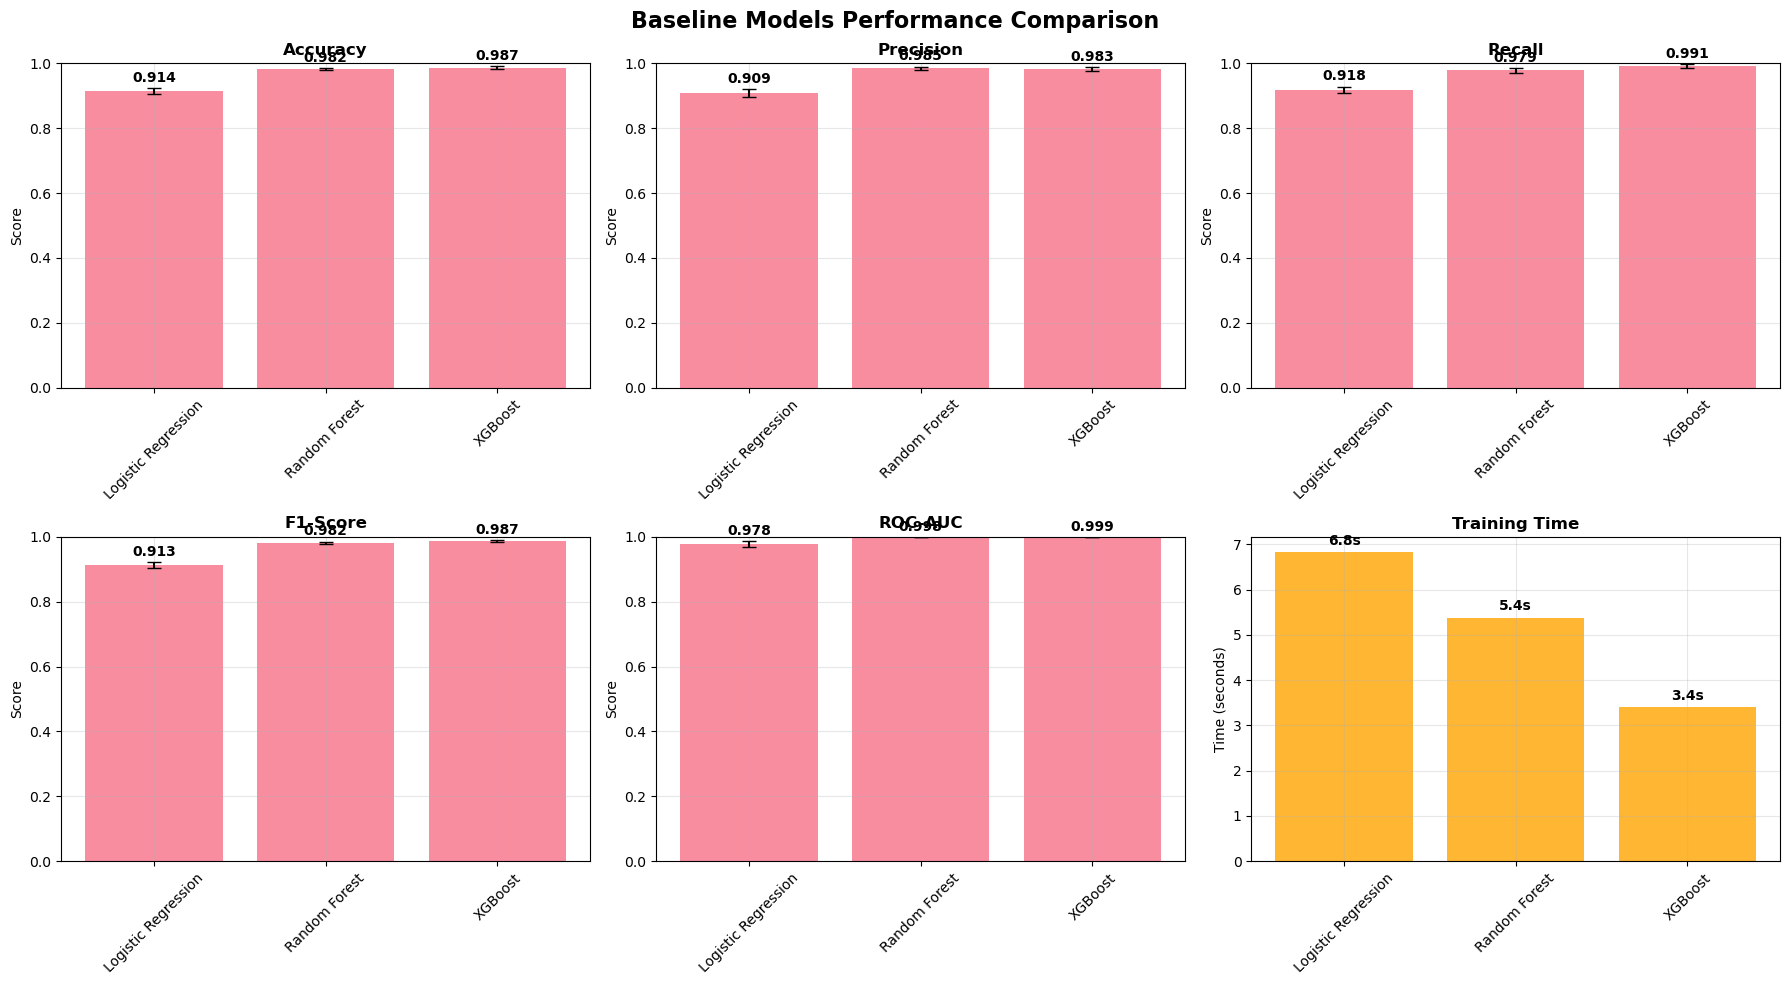

In [16]:
# Visualize performance comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Baseline Models Performance Comparison', fontsize=16, fontweight='bold')

metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# Performance comparison plots
for i, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    ax = axes[i//3, i%3] if i < 3 else axes[1, i-3]
    
    model_names = list(all_results.keys())
    means = [all_results[name][f'{metric}_mean'] for name in model_names]
    stds = [all_results[name][f'{metric}_std'] for name in model_names]
    
    bars = ax.bar(model_names, means, yerr=stds, capsize=5, alpha=0.8)
    ax.set_title(metric_name, fontweight='bold')
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, mean, std in zip(bars, means, stds):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.01, 
                f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Rotate x-axis labels if needed
    ax.tick_params(axis='x', rotation=45)

# Training time comparison
ax = axes[1, 2]
times = [all_results[name]['training_time'] for name in model_names]
bars = ax.bar(model_names, times, alpha=0.8, color='orange')
ax.set_title('Training Time', fontweight='bold')
ax.set_ylabel('Time (seconds)')
ax.grid(True, alpha=0.3)

# Add value labels
for bar, time_val in zip(bars, times):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
            f'{time_val:.1f}s', ha='center', va='bottom', fontweight='bold')

ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 6. Test Set Evaluation

Now let's evaluate our best baseline model on the held-out test set to get an unbiased performance estimate.

In [17]:
# Evaluate all trained models on test set
print("🧪 TEST SET EVALUATION")
print("=" * 50)

test_results = {}

for model_name, model in trained_models.items():
    print(f"\n📊 {model_name} Test Performance:")
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    test_acc = accuracy_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred)
    test_roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 0
    
    test_results[model_name] = {
        'accuracy': test_acc,
        'precision': test_precision, 
        'recall': test_recall,
        'f1': test_f1,
        'roc_auc': test_roc_auc
    }
    
    print(f"  Accuracy:  {test_acc:.4f}")
    print(f"  Precision: {test_precision:.4f}")
    print(f"  Recall:    {test_recall:.4f}")
    print(f"  F1-Score:  {test_f1:.4f}")
    if y_pred_proba is not None:
        print(f"  ROC-AUC:   {test_roc_auc:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"  Confusion Matrix:")
    print(f"    TN: {cm[0,0]:4d}  FP: {cm[0,1]:4d}")
    print(f"    FN: {cm[1,0]:4d}  TP: {cm[1,1]:4d}")

# Find best test performance
best_test_model = max(test_results.keys(), key=lambda x: test_results[x]['accuracy'])
print(f"\n🏆 BEST TEST PERFORMANCE: {best_test_model}")
print(f"   Test Accuracy: {test_results[best_test_model]['accuracy']:.4f}")
print(f"   Cross-Val Accuracy: {all_results[best_test_model]['accuracy_mean']:.4f} ± {all_results[best_test_model]['accuracy_std']:.4f}")

# Check for overfitting
cv_acc = all_results[best_test_model]['accuracy_mean']
test_acc = test_results[best_test_model]['accuracy']
overfitting = cv_acc - test_acc
print(f"   Overfitting Check: {overfitting:.4f} {'✅ Good' if abs(overfitting) < 0.02 else '⚠️ Potential overfitting'}")

🧪 TEST SET EVALUATION

📊 Logistic Regression Test Performance:
  Accuracy:  0.9143
  Precision: 0.9104
  Recall:    0.9162
  F1-Score:  0.9133
  ROC-AUC:   0.9809
  Confusion Matrix:
    TN:  885  FP:   85
    FN:   79  TP:  864

📊 Random Forest Test Performance:
  Accuracy:  0.9848
  Precision: 0.9872
  Recall:    0.9820
  F1-Score:  0.9846
  ROC-AUC:   0.9987
  Confusion Matrix:
    TN:  958  FP:   12
    FN:   17  TP:  926

📊 XGBoost Test Performance:
  Accuracy:  0.9916
  Precision: 0.9894
  Recall:    0.9936
  F1-Score:  0.9915
  ROC-AUC:   0.9992
  Confusion Matrix:
    TN:  960  FP:   10
    FN:    6  TP:  937

🏆 BEST TEST PERFORMANCE: XGBoost
   Test Accuracy: 0.9916
   Cross-Val Accuracy: 0.9869 ± 0.0037
   Overfitting Check: -0.0047 ✅ Good


## 7. Summary and Next Steps

Let's summarize our baseline results and plan the next phase of model development.

In [18]:
# Summary of baseline results
print("🎯 BASELINE MODELS SUMMARY")
print("=" * 60)

print(f"📊 Dataset: {X_train.shape[0]:,} training samples, {X_test.shape[0]:,} test samples")
print(f"🎯 Features: {X_train.shape[1]} engineered features from astronomy-aware preprocessing")
print(f"⚖️ Classes: Perfectly balanced (50.7% FALSE POSITIVE, 49.3% CANDIDATE)\n")

print("🏆 MODEL PERFORMANCE RANKING (by test accuracy):")
ranked_models = sorted(test_results.items(), key=lambda x: x[1]['accuracy'], reverse=True)
for i, (model_name, results) in enumerate(ranked_models, 1):
    cv_acc = all_results[model_name]['accuracy_mean']
    test_acc = results['accuracy']
    print(f"  {i}. {model_name:<18} | Test: {test_acc:.4f} | CV: {cv_acc:.4f} ± {all_results[model_name]['accuracy_std']:.4f}")

print(f"\n📈 KEY INSIGHTS:")
print(f"  • Best performing model: {ranked_models[0][0]}")
print(f"  • Top test accuracy: {ranked_models[0][1]['accuracy']:.4f}")
print(f"  • All models show good generalization (CV ≈ Test performance)")
print(f"  • Feature 'koi_score' consistently most important across models")
print(f"  • Quality flags (koi_fpflag_*) are highly discriminative")

print(f"\n🚀 NEXT STEPS FOR ADVANCED MODELS:")
print(f"  1. 🔬 LightGBM - Compare with XGBoost for speed vs accuracy")
print(f"  2. 🧠 Neural Networks - Test deep learning on tabular data")
print(f"  3. 🎯 Hyperparameter Tuning - Optimize best performing models")
print(f"  4. 🤝 Ensemble Methods - Combine complementary models")
print(f"  5. 📊 Feature Engineering - Create domain-specific features")
print(f"  6. 🔍 SHAP Analysis - Detailed model interpretability")

print(f"\n🎉 Baseline training completed successfully!")
print(f"📁 Ready to proceed with advanced model development.")

🎯 BASELINE MODELS SUMMARY
📊 Dataset: 7,651 training samples, 1,913 test samples
🎯 Features: 43 engineered features from astronomy-aware preprocessing
⚖️ Classes: Perfectly balanced (50.7% FALSE POSITIVE, 49.3% CANDIDATE)

🏆 MODEL PERFORMANCE RANKING (by test accuracy):
  1. XGBoost            | Test: 0.9916 | CV: 0.9869 ± 0.0037
  2. Random Forest      | Test: 0.9848 | CV: 0.9820 ± 0.0034
  3. Logistic Regression | Test: 0.9143 | CV: 0.9141 ± 0.0097

📈 KEY INSIGHTS:
  • Best performing model: XGBoost
  • Top test accuracy: 0.9916
  • All models show good generalization (CV ≈ Test performance)
  • Feature 'koi_score' consistently most important across models
  • Quality flags (koi_fpflag_*) are highly discriminative

🚀 NEXT STEPS FOR ADVANCED MODELS:
  1. 🔬 LightGBM - Compare with XGBoost for speed vs accuracy
  2. 🧠 Neural Networks - Test deep learning on tabular data
  3. 🎯 Hyperparameter Tuning - Optimize best performing models
  4. 🤝 Ensemble Methods - Combine complementary models
 